In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import json
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from climb_diffusion_model import ClimbDiffusionModel, ClimbDiffusionTrainer, ClimbDiffusionSampler, ClimbDiffusionConfig
from climb_conversion import get_preprocessed_3d_features, ClimbingDataset

In [2]:
# Configuration
config = ClimbDiffusionConfig(
    num_scalar_features=1, 
    num_roles=5,
    num_layers=3,
    embedding_dim=128
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ClimbDiffusionModel(config).to(device)

In [3]:
# Reload model and sample
state = torch.load('climb_diffusion_v1.pt', map_location=device)
model.load_state_dict(state, strict=True)

N_SAMPLES = 5

sampler = ClimbDiffusionSampler(
    model=model,
    config=config,
    nodes_per_sample=30,  # Max nodes (including padding)
    device='cpu',
    num_steps=50          # 50 steps is usually enough for a quick check
)

# 2. Generate Batch of Climbs
# This returns a dictionary-like object with x (pos), v (vec), s (scalar), r (roles)
print("Sampling climbs...")
samples = sampler.sample(num_samples=N_SAMPLES)
print(f"Generated {N_SAMPLES} samples!")

C:\Users\EvanM\AppData\Local\Temp\ipykernel_16836\161669516.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('climb_diffusion_v1.pt', map_location=devi

Sampling climbs...
Generated 5 samples!


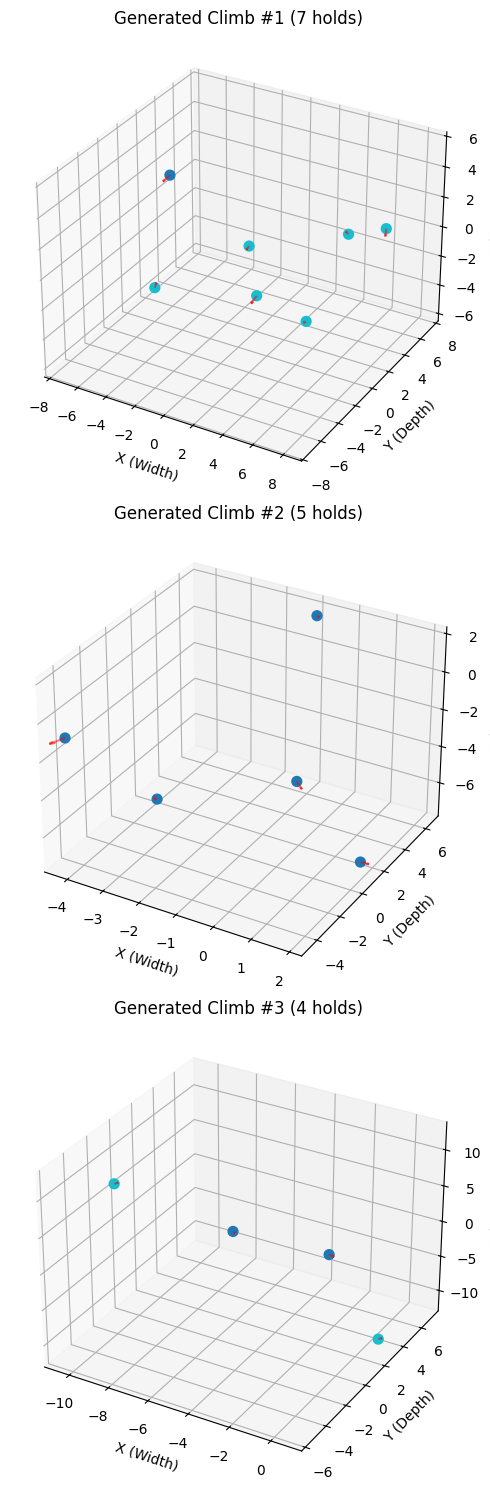

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_generated_climbs(samples, num_to_plot=3, null_token=4):
    """
    Visualizes generated climbs.
    - Scatter points for Hold Positions (x)
    - Arrows for Pull Vectors (v)
    - Colors for Roles (r)
    """
    # 1. Unpack data to CPU numpy
    x_all = samples.x.cpu().numpy()
    v_all = samples.v.cpu().numpy()
    r_all = samples.r.cpu().numpy().argmax(axis=1) if samples.r.ndim > 1 else samples.r.cpu().numpy()
    
    # 2. Reshape into (Num_Samples, Nodes_Per_Sample, Features)
    # We assume nodes_per_sample is 30 based on your config
    nodes_per_climb = 30 
    num_generated = x_all.shape[0] // nodes_per_climb
    
    x_reshaped = x_all.reshape(num_generated, nodes_per_climb, 3)
    v_reshaped = v_all.reshape(num_generated, nodes_per_climb, 3)
    r_reshaped = r_all.reshape(num_generated, nodes_per_climb)

    # 3. Plot loop
    fig = plt.figure(figsize=(15, 5 * num_to_plot))
    
    for i in range(min(num_generated, num_to_plot)):
        ax = fig.add_subplot(num_to_plot, 1, i + 1, projection='3d')
        
        # Extract single climb
        x_climb = x_reshaped[i]
        v_climb = v_reshaped[i]
        r_climb = r_reshaped[i]
        
        # FILTER: Only plot non-NULL holds
        mask = r_climb != null_token
        
        if mask.sum() == 0:
            ax.text(0, 0, 0, "Empty Climb (All Null)", color='red')
            continue

        valid_x = x_climb[mask]
        valid_v = v_climb[mask]
        valid_r = r_climb[mask]

        # Scatter Plot (Positions)
        # Color by Role
        scatter = ax.scatter(valid_x[:, 0], valid_x[:, 1], valid_x[:, 2], 
                             c=valid_r, cmap='tab10', s=50, depthshade=False, label='Holds')

        # Quiver Plot (Vectors)
        # Draws arrows starting at 'x' pointing in direction 'v'
        ax.quiver(
            valid_x[:, 0], valid_x[:, 1], valid_x[:, 2], # Start points
            valid_v[:, 0], valid_v[:, 1], valid_v[:, 2], # Directions
            length=0.2, color='red', alpha=0.5, label='Pull Dir'
        )

        ax.set_title(f"Generated Climb #{i+1} ({mask.sum()} holds)")
        ax.set_xlabel("X (Width)")
        ax.set_ylabel("Y (Depth)")
        ax.set_zlabel("Z (Height)")
        
        # Set consistent axis limits if you know your wall dimensions
        # ax.set_xlim(0, 3)
        # ax.set_zlim(0, 4) 

    plt.tight_layout()
    plt.show()

# Run the visualizer
plot_generated_climbs(samples)

In [ ]:
# ---------------------------------------------------------------------------------
# Model Training
# ---------------------------------------------------------------------------------
EPOCHS = 400
BATCH_SIZE = 64

# Data Setup
climb_dataset = get_preprocessed_3d_features(db_path='../data/storage.db',wall_id='wall-443c15cd12e0')
loader = DataLoader(climb_dataset, batch_size=64, shuffle=True)
print(f"Training on {device}")

trainer = ClimbDiffusionTrainer(model, config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Calculate Loss (Forward Diffusion + Prediction)
        loss_dict = trainer.get_loss(batch)
        loss = loss_dict['weighted_sum']
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Pos: {loss_dict['pos']:.4f} | Pull: {loss_dict['roles']:.4f} | Features: {loss_dict['scalars']:.4f} | Roles: {loss_dict['roles']:.4f}")
# Save Model
torch.save(model.state_dict(), "climb_diffusion_v2.pt")

Training on cpu
Epoch 000 | Loss: 1.2311 | Pos: 0.0337 | Pull: 0.6378 | Features: 0.0516 | Roles: 0.6378
